Setup

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

from src.flat_mae import models_mae
from src.data.flat_data import make_flat_wds_dataset, make_flat_transform

plt.rcParams["figure.dpi"] = 100

In [2]:
# Colormap for fMRI visualization
FC_COLORS = np.array(
    [
        [64, 80, 160],
        [64, 96, 176],
        [96, 192, 240],
        [144, 208, 224],
        [255, 255, 255],
        [240, 240, 96],
        [240, 208, 64],
        [224, 112, 64],
        [224, 64, 48],
    ],
    dtype=np.uint8,
)
FC_CMAP = LinearSegmentedColormap.from_list("fc", FC_COLORS / 255.0)
FC_CMAP.set_bad("gray")

Dataset

In [ ]:
data_dir = Path("/teamspace/gcs_folders/share/fmri-fm/datasets")

# Load pretrained checkpoint
ckpt = torch.load("../checkpoints/fm_mae_pretrain_vit_small.pth", weights_only=True)
args = ckpt["args"]
state = ckpt["model"]

# Create dataset
dataset_files = sorted((data_dir / "hcp-flat/").glob("hcp-flat_*.tar"))
dataset = make_flat_wds_dataset(
    [str(f) for f in dataset_files],
    clipping="sequential",
    shuffle=False,
)

# Define transform
transform = make_flat_transform(
    img_size=(224, 560),
    clip_vmax=args["clip_vmax"],
    normalize=args["normalize"],
)
dataset = dataset.map(transform)
print(f"Found {len(dataset_files)} dataset shards.")

Found 2000 dataset shards.


Balanced Sampling

In [13]:
label_counts = Counter()
for i, sample in enumerate(dataset):
    label_counts[sample["task"]] += 1
    if i > 1000:
        break
print(label_counts)

n_samples_per_class = min(label_counts.values())
balanced_samples = []
class_counters = {cls: 0 for cls in label_counts.keys()}

# Collect balanced samples
for sample in dataset:
    cls = sample["task"]
    if class_counters[cls] < n_samples_per_class:
        balanced_samples.append(sample)
        class_counters[cls] += 1
    if all(count >= n_samples_per_class for count in class_counters.values()):
        break
print(f"Collected {len(balanced_samples)} balanced samples for PCA.")

Counter({'REST2': 270, 'REST1': 164, 'MOVIE2': 114, 'SOCIAL': 108, 'LANGUAGE': 84, 'GAMBLING': 66, 'WM': 61, 'RELATIONAL': 50, 'EMOTION': 49, 'MOTOR': 36})
Collected 360 balanced samples for PCA.


In [14]:
# Organize by class
class_to_images = {cls: [] for cls in label_counts.keys()}
class_to_masks = {cls: [] for cls in label_counts.keys()}

for s in balanced_samples:
    cls = s["task"]
    img = s["image"].squeeze(0) if s["image"].shape[0] == 1 else s["image"]
    mask = s["mask"].squeeze(0) if s["mask"].shape[0] == 1 else s["mask"]
    class_to_images.setdefault(cls, []).append(img)
    class_to_masks.setdefault(cls, []).append(mask)

for cls in class_to_images:
    class_to_images[cls] = torch.stack(class_to_images[cls], dim=0)
    class_to_masks[cls] = torch.stack(class_to_masks[cls], dim=0)
    print(
        f"{cls}: images shape={class_to_images[cls].shape}, masks shape={class_to_masks[cls].shape}"
    )

RELATIONAL: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
LANGUAGE: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
MOTOR: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
GAMBLING: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
WM: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
MOVIE2: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
REST2: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
SOCIAL: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
EMOTION: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])
REST1: images shape=torch.Size([36, 16, 224, 560]), masks shape=torch.Size([36, 1, 224, 560])


Model

In [15]:
# Load model
model = models_mae.__dict__[args["model"]](**args)
model.load_state_dict(state)
model.eval()

patch_size = args["t_patch_size"]
generator = torch.Generator().manual_seed(42)

# Extract embeddings
class_to_embeddings = {}
for cls, imgs in class_to_images.items():
    imgs = imgs.unsqueeze(1)
    with torch.inference_mode():
        embeddings = model.forward_embedding(imgs, generator=generator)[2]
    class_to_embeddings[cls] = embeddings
    print(f"{cls}: embeddings shape={embeddings.shape}")

img_size (224, 560) patch_size (16, 16) frames 16 t_patch_size 16
model initialized
RELATIONAL: embeddings shape=torch.Size([36, 490, 384])
LANGUAGE: embeddings shape=torch.Size([36, 490, 384])
MOTOR: embeddings shape=torch.Size([36, 490, 384])
GAMBLING: embeddings shape=torch.Size([36, 490, 384])
WM: embeddings shape=torch.Size([36, 490, 384])
MOVIE2: embeddings shape=torch.Size([36, 490, 384])
REST2: embeddings shape=torch.Size([36, 490, 384])
SOCIAL: embeddings shape=torch.Size([36, 490, 384])
EMOTION: embeddings shape=torch.Size([36, 490, 384])
REST1: embeddings shape=torch.Size([36, 490, 384])


Embeddings

In [16]:
# Prepare embeddings for PCA (mask background)
class_to_embeddings_for_pca = {}
class_to_patch_masks = {}

for cls, embeddings in class_to_embeddings.items():
    masks = class_to_masks[cls]
    # Create patch-level masks
    patch_mask = F.avg_pool2d(masks, kernel_size=patch_size, stride=patch_size) > 0
    patch_mask = patch_mask.view(embeddings.shape[0], -1)
    class_to_patch_masks[cls] = patch_mask
    # Collect valid (foreground) embeddings
    embeddings_list = [embeddings[i][patch_mask[i]] for i in range(embeddings.shape[0])]
    embeddings_for_pca = torch.cat(embeddings_list, dim=0)
    class_to_embeddings_for_pca[cls] = embeddings_for_pca
    print(f"{cls}: total patches for PCA={embeddings_for_pca.shape[0]}")

RELATIONAL: total patches for PCA=13104
LANGUAGE: total patches for PCA=13104
MOTOR: total patches for PCA=13104
GAMBLING: total patches for PCA=13104
WM: total patches for PCA=13104
MOVIE2: total patches for PCA=13104
REST2: total patches for PCA=13104
SOCIAL: total patches for PCA=13104
EMOTION: total patches for PCA=13104
REST1: total patches for PCA=13104


PCA

In [17]:
all_embeddings = torch.cat(list(class_to_embeddings_for_pca.values()))
pca = PCA(n_components=3, whiten=True, random_state=42)
pca.fit(all_embeddings.numpy())

# Transform each task using the same PCA
class_to_pca = {}
for cls, emb in class_to_embeddings_for_pca.items():
    x_pca = pca.transform(emb.numpy())
    class_to_pca[cls] = x_pca
    print(f"{cls}: PCA transformed shape={x_pca.shape}")

RELATIONAL: PCA transformed shape=(13104, 3)
LANGUAGE: PCA transformed shape=(13104, 3)
MOTOR: PCA transformed shape=(13104, 3)
GAMBLING: PCA transformed shape=(13104, 3)
WM: PCA transformed shape=(13104, 3)
MOVIE2: PCA transformed shape=(13104, 3)
REST2: PCA transformed shape=(13104, 3)
SOCIAL: PCA transformed shape=(13104, 3)
EMOTION: PCA transformed shape=(13104, 3)
REST1: PCA transformed shape=(13104, 3)


In [18]:
# Reconstruct PCA maps
class_to_pca_samples = {}
for cls, x_pca in class_to_pca.items():
    patch_mask = class_to_patch_masks[cls].cpu().numpy()
    N_cls, n_patches = patch_mask.shape

    x_pca_samples = []
    start_idx = 0
    for i in range(N_cls):
        mask = patch_mask[i]
        valid_count = mask.sum()

        # Create full patch array with zeros for background
        x_pca_full = np.zeros((n_patches, 3))
        x_pca_full[mask] = x_pca[start_idx : start_idx + valid_count]
        x_pca_samples.append(x_pca_full)
        start_idx += valid_count
    class_to_pca_samples[cls] = x_pca_samples

Visualization

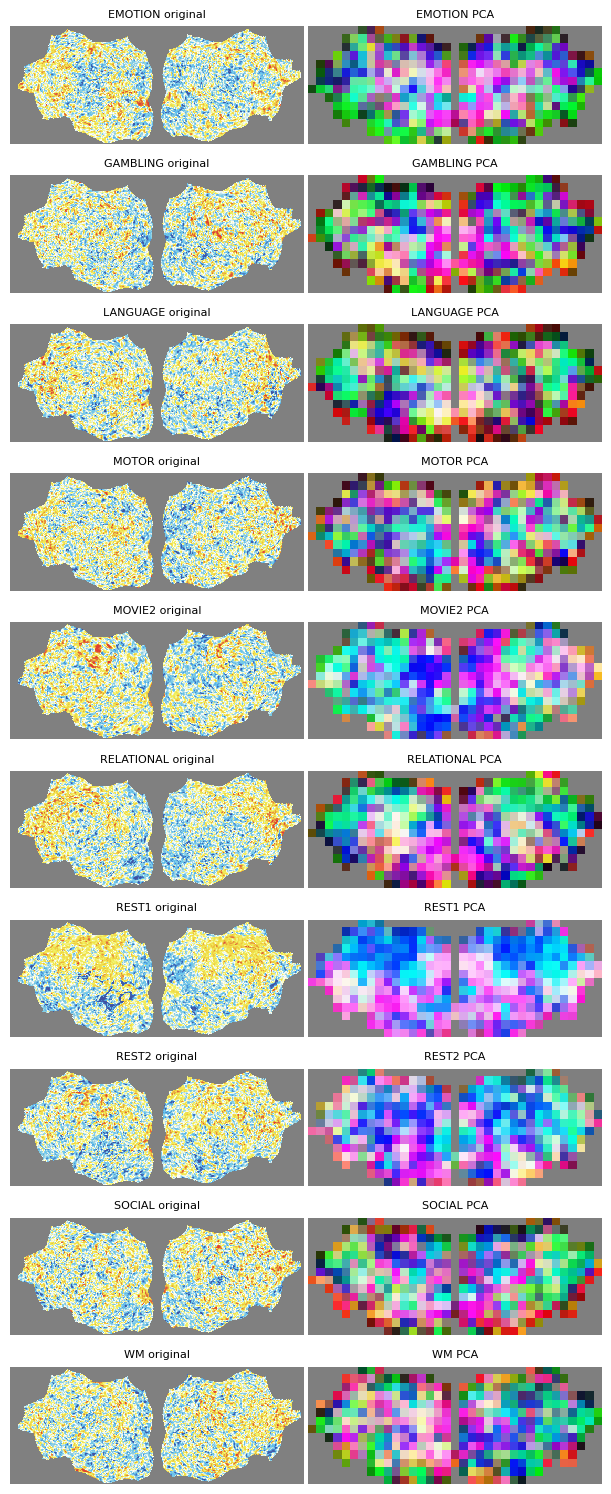

In [19]:
# Average visualization
H, W = next(iter(class_to_images.values())).shape[2:]
h_patches, w_patches = H // patch_size, W // patch_size
n_classes = len(class_to_pca_samples)

fig, axs = plt.subplots(n_classes, 2, figsize=(6, n_classes * 1.5))

for row_idx, cls in enumerate(sorted(class_to_pca_samples.keys())):
    # Original image
    ax = axs[row_idx, 0]
    img_orig = class_to_images[cls][0][0].numpy()
    img_mask = class_to_masks[cls][0][0].numpy()
    img_orig = np.where(img_mask > 0, img_orig, np.nan)
    ax.imshow(img_orig, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    ax.set_title(f"{cls} original", fontsize=8)
    ax.axis("off")

    # PCA maps
    ax = axs[row_idx, 1]
    # Concatenate PCA embeddings for all 36 samples
    all_pca_patches = np.concatenate(class_to_pca_samples[cls], axis=0)

    # Reshape into patch grid
    projected_image = torch.from_numpy(all_pca_patches[: h_patches * w_patches]).view(
        h_patches, w_patches, 3
    )
    projected_image = torch.sigmoid(projected_image * 2.0)

    # Combine masks across all samples
    masks_stack = torch.stack([m[0] for m in class_to_masks[cls]], dim=0).float()
    mask_pooled = F.avg_pool2d(
        masks_stack.unsqueeze(1), kernel_size=patch_size, stride=patch_size
    )
    mask_combined = mask_pooled.any(dim=0).squeeze().numpy() > 0

    projected_image[~mask_combined] = 0.5  # gray out background

    ax.imshow(projected_image.numpy(), interpolation="none")
    ax.set_title(f"{cls} PCA", fontsize=8)
    ax.axis("off")

plt.tight_layout(pad=0.3)
plt.show()

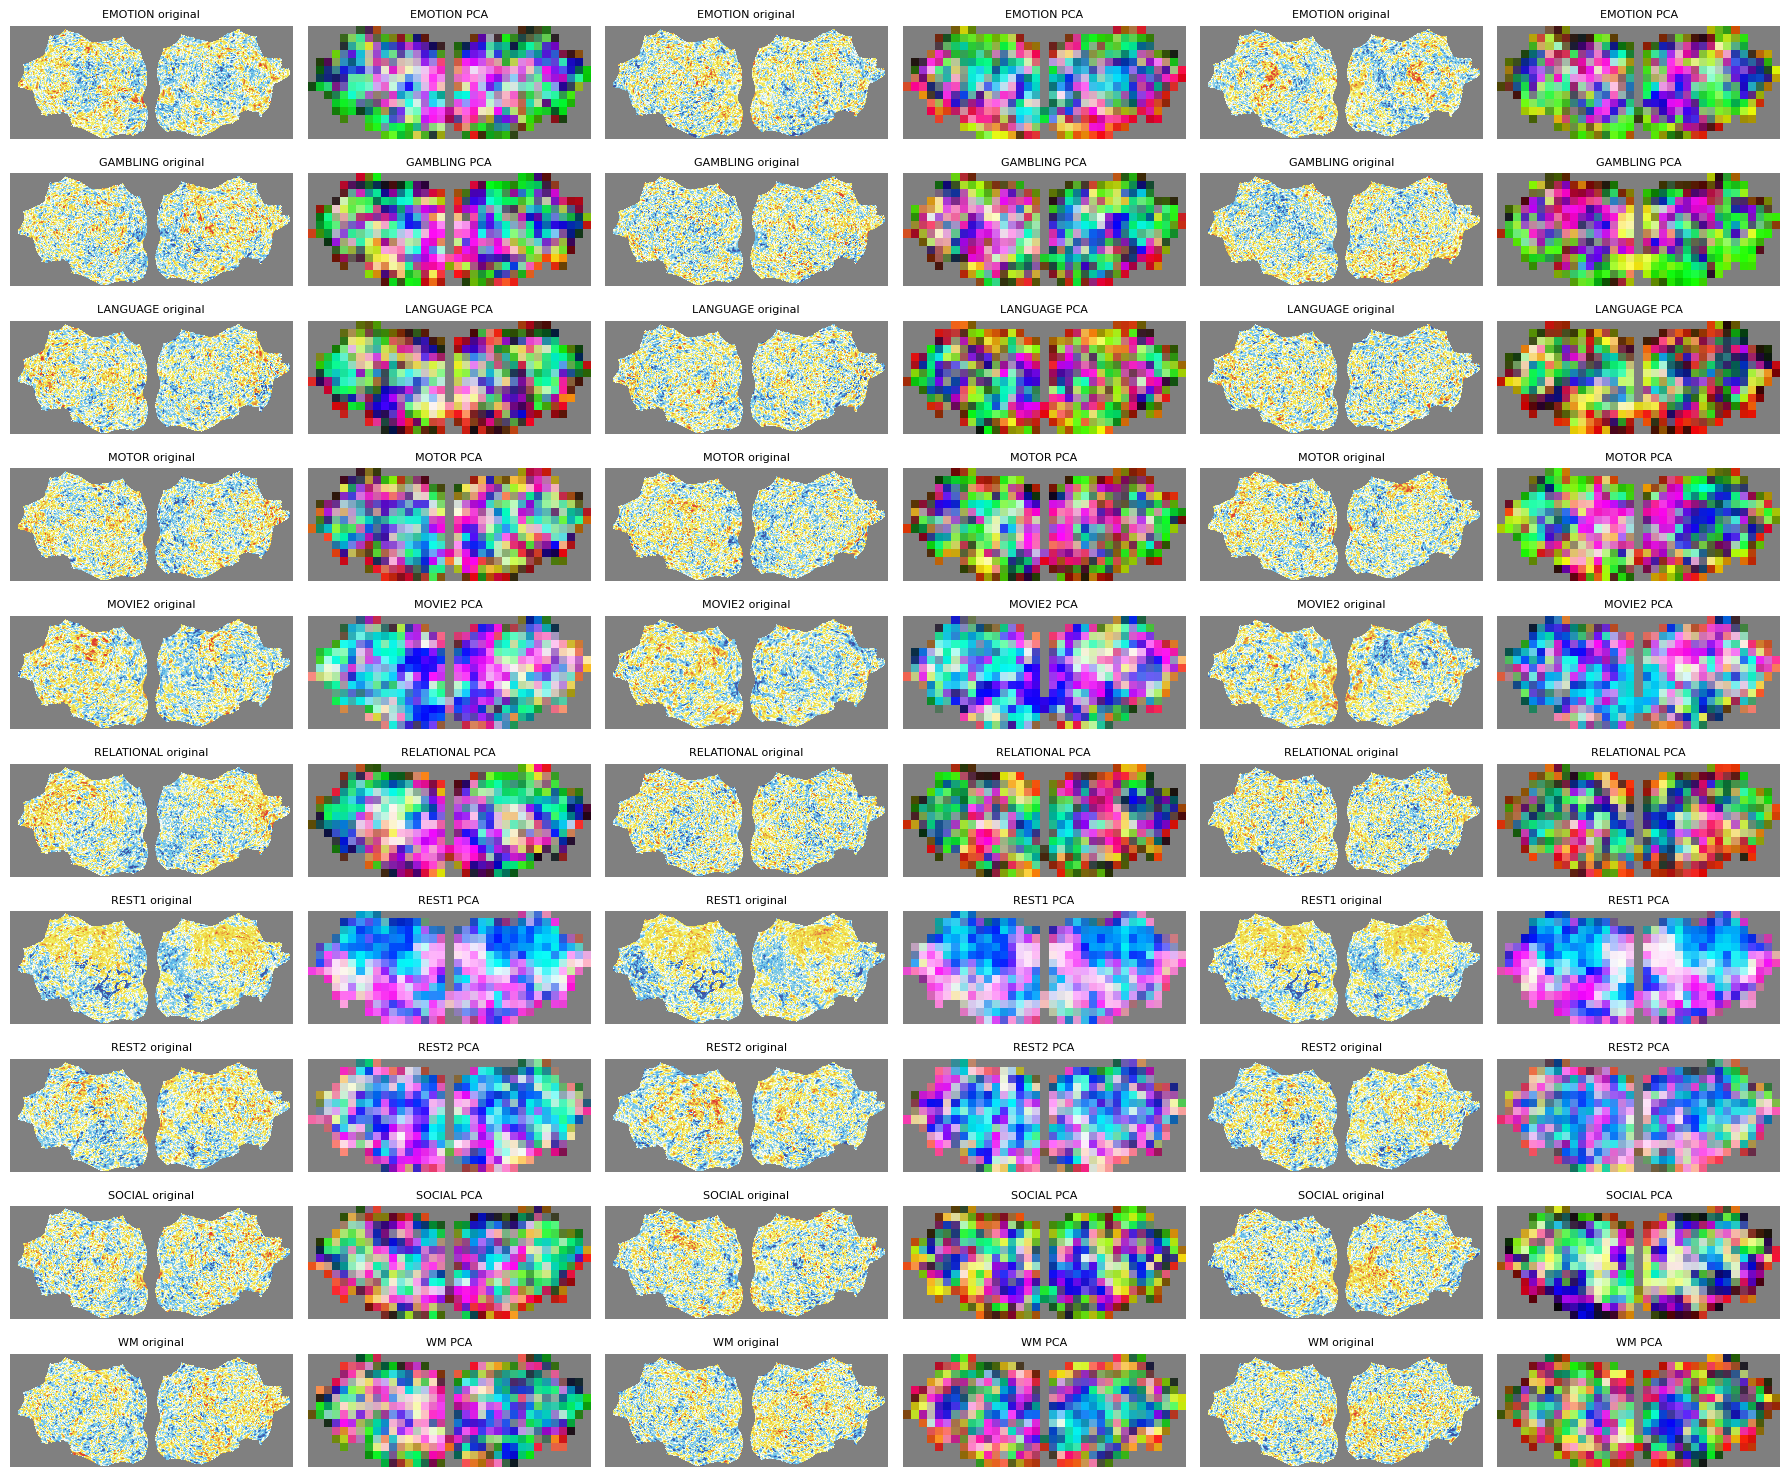

In [20]:
# Individual examples visualization
n_examples = 3  # number of examples per class
classes = sorted(class_to_pca_samples.keys())
n_classes = len(classes)

H, W = next(iter(class_to_images.values())).shape[2:]
h_patches = H // patch_size
w_patches = W // patch_size

fig, axs = plt.subplots(
    n_classes, n_examples * 2, figsize=(n_examples * 2 * 3, n_classes * 1.5)
)

for row_idx, cls in enumerate(classes):
    for ex_idx in range(n_examples):
        # Original image
        ax = axs[row_idx, ex_idx * 2]
        img_orig = class_to_images[cls][ex_idx][0].numpy()
        img_mask = class_to_masks[cls][ex_idx][0].numpy()
        img_orig = np.where(img_mask > 0, img_orig, np.nan)
        ax.imshow(img_orig, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
        ax.set_title(f"{cls} original", fontsize=8)
        ax.axis("off")

        # PCA map
        ax = axs[row_idx, ex_idx * 2 + 1]
        pca_patches = class_to_pca_samples[cls][ex_idx]
        pca_image = pca_patches.reshape(h_patches, w_patches, 3)
        pca_image = torch.from_numpy(pca_image).float()
        pca_image = torch.sigmoid(pca_image * 2.0)

        # Apply patch-level mask
        mask_2d = class_to_masks[cls][ex_idx][0].numpy()
        mask_patches = (
            F.avg_pool2d(
                torch.from_numpy(mask_2d).unsqueeze(0).unsqueeze(0).float(),
                kernel_size=patch_size,
                stride=patch_size,
            )
            .squeeze()
            .numpy()
            > 0
        )
        pca_display = pca_image.numpy()
        pca_display[~mask_patches] = 0.5  # Gray out background

        ax.imshow(pca_display, interpolation="none")
        ax.set_title(f"{cls} PCA", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.savefig("pca_visualization.png", dpi=150, bbox_inches="tight")
plt.show()

The End